<a href="https://colab.research.google.com/github/AbdulAleem11/Flask/blob/master/Big_Mart_Sales_Prediction_using_XGBoost_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING NECESSARY LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler 

**LOADING THE DATASET**

In [ ]:
df=pd.read_csv('/content/Train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df.shape

(8523, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

<Figure size 720x432 with 0 Axes>

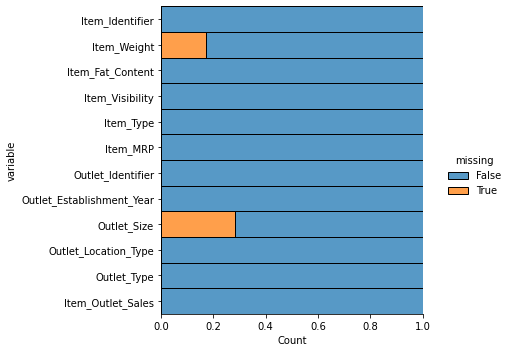

In [ ]:
plt.figure(figsize=(10,6))
sb.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

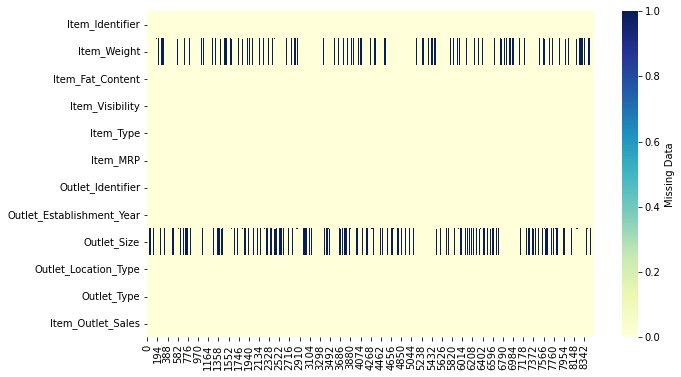

In [ ]:
plt.figure(figsize=(10,6))
sb.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})


* we can see that there are 1463 missing values in Item_Weight and 2410 missing values in Outlet_Size.

In [ ]:
df.groupby('Item_Type')['Item_Weight'].mean()

Item_Type
Baking Goods             12.277108
Breads                   11.346936
Breakfast                12.768202
Canned                   12.305705
Dairy                    13.426069
Frozen Foods             12.867061
Fruits and Vegetables    13.224769
Hard Drinks              11.400328
Health and Hygiene       13.142314
Household                13.384736
Meat                     12.817344
Others                   13.853285
Seafood                  12.552843
Snack Foods              12.987880
Soft Drinks              11.847460
Starchy Foods            13.690731
Name: Item_Weight, dtype: float64

* Here we can see the mean Item_Weight of respective Item_Type. we can fill the missing values in Item_Type w.r.t corresponding mean of Item_Type.

In [ ]:
df['Item_Weight']=df.groupby('Item_Type')['Item_Weight'].apply(lambda x:x.fillna(x.mean()))

In [ ]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

* we successfully filled our item_weight with respective mean and now there is no missing value in that column.

In [ ]:
mode_OS = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()))
mode_OS

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


* Since the Outlet_Size is not a numeric datatype we will select the mode based on the respective Outlet_Type and fill the missing values in Outlet_Size with this respective value.

In [ ]:
df.loc[ df['Outlet_Size'].isnull(), 'Outlet_Size'] = df.loc[df['Outlet_Size'].isnull(),'Outlet_Type'].apply(lambda x: mode_OS[x])

In [ ]:
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

* we can see our data is now free from missing values to procede further.

In [ ]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857890,0.066132,140.992782,1997.831867,2181.288914
std,4.232804,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.867061,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


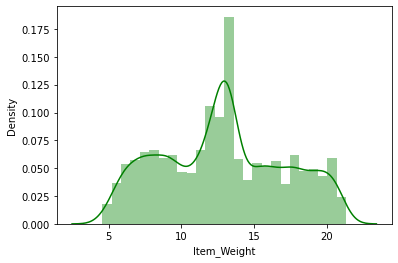

In [ ]:
sb.distplot(df['Item_Weight'],color='green')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


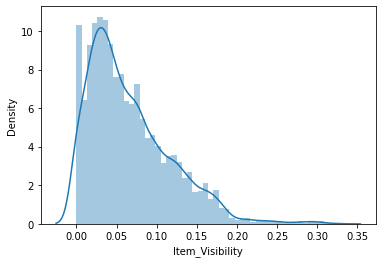

In [ ]:
sb.distplot(df['Item_Visibility'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


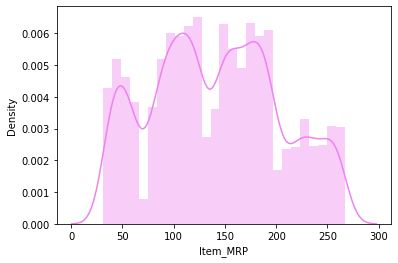

In [ ]:
sb.distplot(df['Item_MRP'],color='violet')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


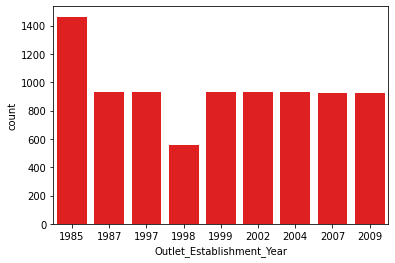

In [ ]:
sb.countplot(df['Outlet_Establishment_Year'],color='red')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


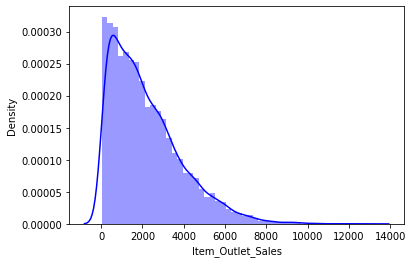

In [ ]:
sb.distplot(df['Item_Outlet_Sales'],color='blue')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


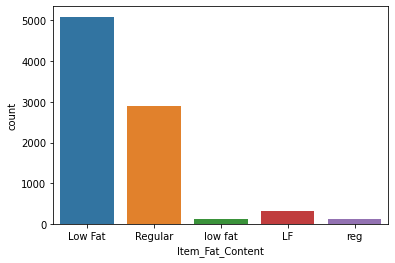

In [ ]:
sb.countplot(df['Item_Fat_Content'])

* we can see that in Item_Fat_Content column Both LF and lowfat represents Low Fat similiarly, reg represents Regular.
* we need replace the LF and lowfat into Low Fat and reg into Regular in such a way we will be left with two types of data in Item_Fat_Content column. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


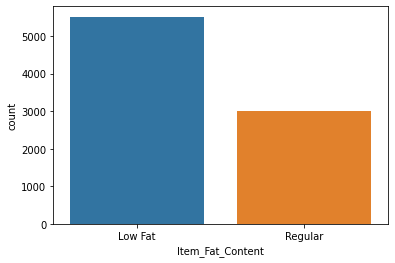

In [ ]:
df.replace({'Item_Fat_Content':{'LF':'Low Fat','low fat':'Low Fat','reg':'Regular' }},inplace=True)
sb.countplot(df['Item_Fat_Content'])


* Now our Item_Fat_Content column is free from duplication.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


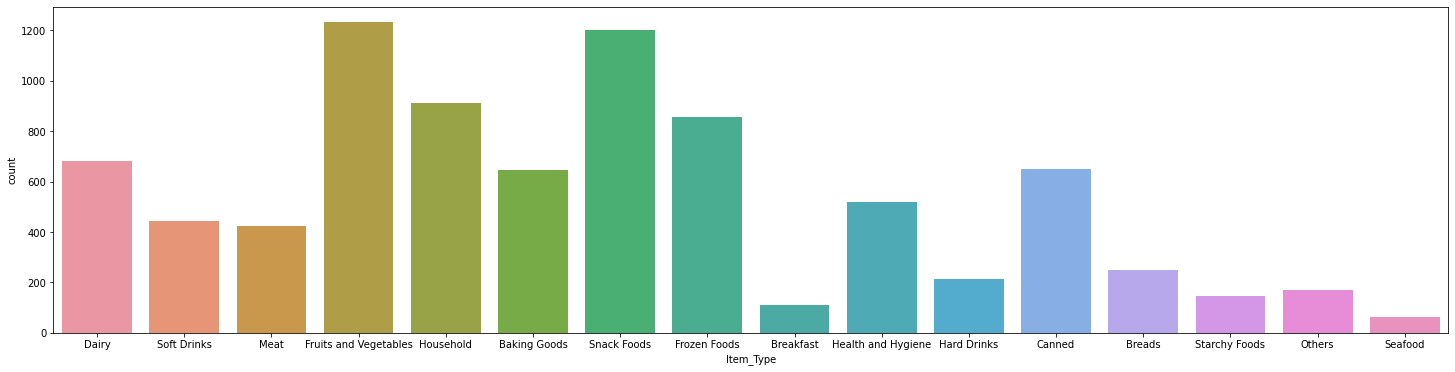

In [ ]:
plt.figure(figsize=(25,6))
sb.countplot(df['Item_Type'])

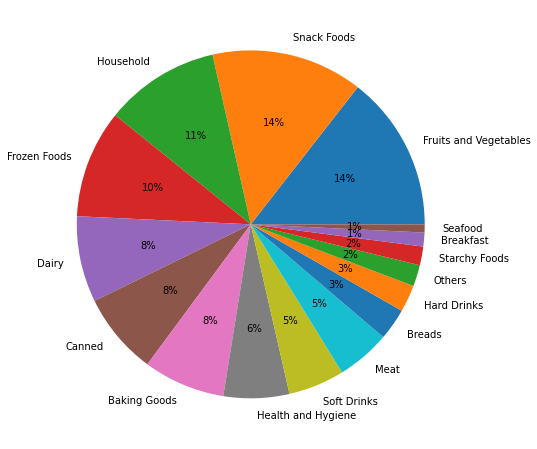

In [ ]:
plt.figure(figsize = (8,8))
plt.pie(x = df['Item_Type'].value_counts(), data = df, labels= df['Item_Type'].value_counts().index,autopct='%.0f%%')
plt.show()

* we can see visualize that Fruits and vegetables and Snack Foods that are most frequently bought items.
* whereas seafood is less purchased item.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


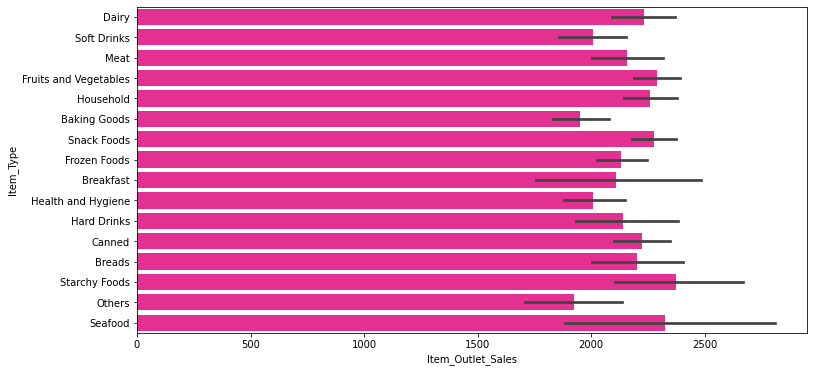

In [ ]:
plt.figure(figsize=(12,6))
sb.barplot(df['Item_Outlet_Sales'],df['Item_Type'],orient='h',color='deeppink')

* Eventhough fruits and vegetables were frequently purchased we visualize that the income generated maximum from starchyfoods. hence we can infer that starchy food is costlier than fruits and vegetables.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


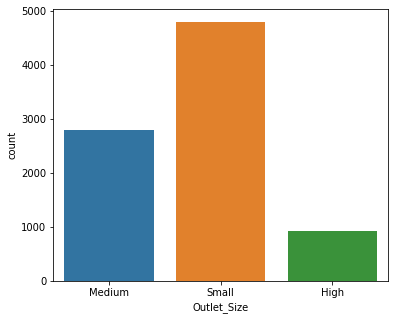

In [ ]:
plt.figure(figsize=(6,5))
sb.countplot(df['Outlet_Size'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


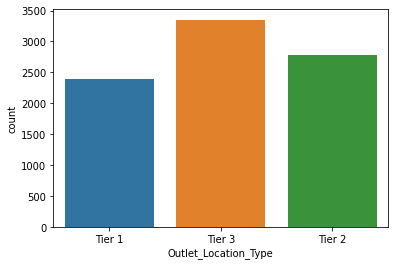

In [ ]:
sb.countplot(df['Outlet_Location_Type'])

* we can understand that majority of the big marts are small in size and located in Tier 3.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


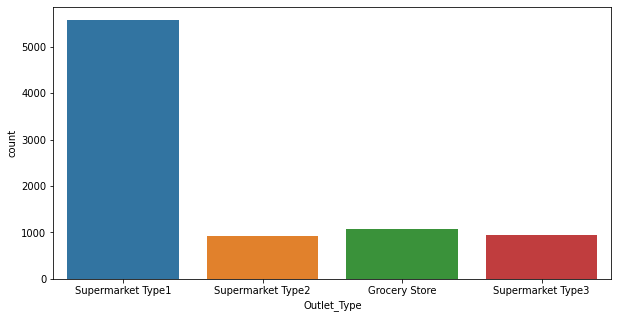

In [ ]:
plt.figure(figsize=(10,5))
sb.countplot(df['Outlet_Type'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


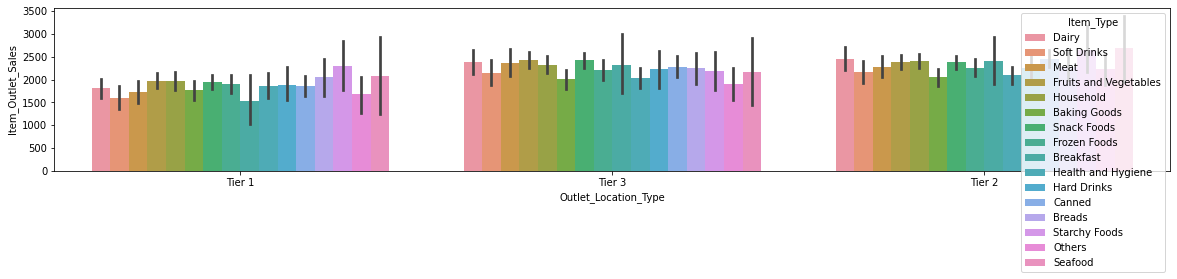

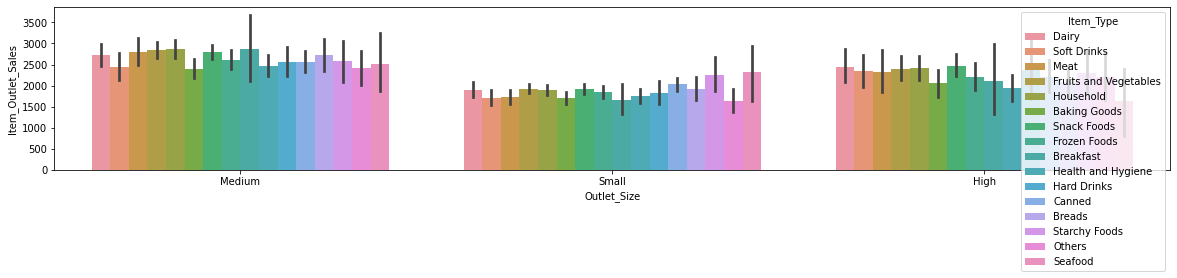

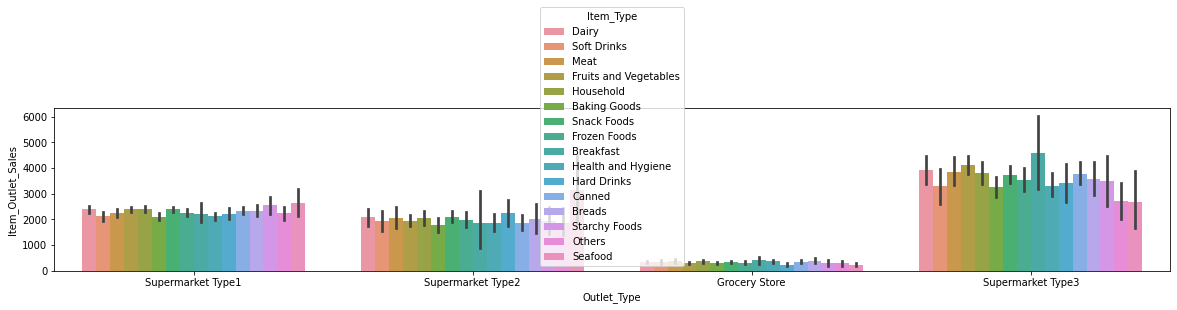

In [ ]:
k=[df['Outlet_Location_Type'],df['Outlet_Size'],df['Outlet_Type']]
for i in k:
  plt.figure(figsize=(20,3))
  sb.barplot(i,df['Item_Outlet_Sales'],hue=df['Item_Type'])

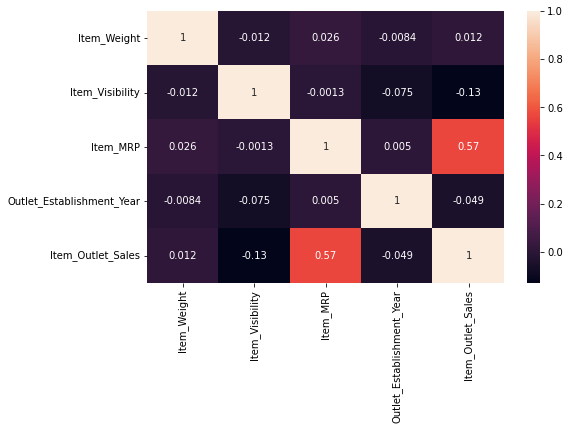

In [ ]:
plt.figure(figsize=(8,5))
sb.heatmap(df.corr(),annot=True)

In [ ]:
corr=pd.DataFrame(df.corr().iloc[:,-1])
corr

,Item_Outlet_Sales
Item_Weight,0.012088
Item_Visibility,-0.128625
Item_MRP,0.567574
Outlet_Establishment_Year,-0.049135
Item_Outlet_Sales,1.000000


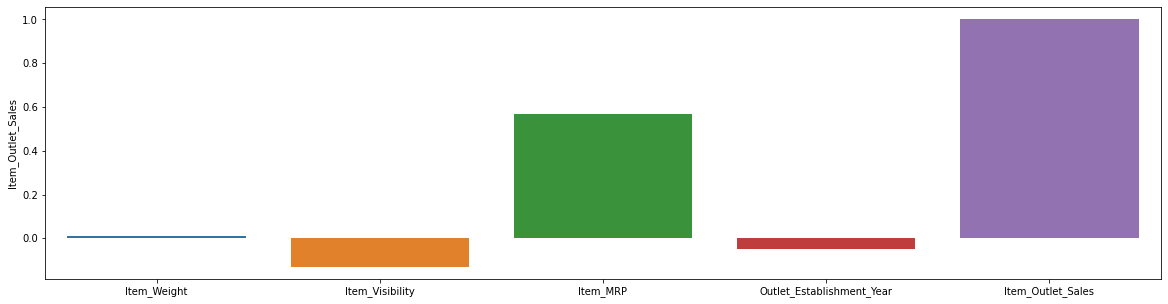

In [ ]:
plt.figure(figsize=(20,5))
sb.barplot(x=corr.index,y=corr['Item_Outlet_Sales'])

In [ ]:
df.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138


In [ ]:
df.drop(['Item_Identifier','Outlet_Identifier'],axis='columns',inplace=True)

* we can see that the columns Item_Identifier and Outlet_Identifier dont have much influence on our sales so we dropped it.

In [ ]:
lb=LabelEncoder()

In [ ]:
for i in df[['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type']]:
  df[i]=lb.fit_transform(df[i])


In [ ]:
df.head(1)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.3,0,0.016047,4,249.8092,1999,1,0,1,3735.138


* we have encoded our object columns so that the machine can learn our data much easily.

In [ ]:
x=df.drop(['Item_Outlet_Sales'],axis='columns')
y=df['Item_Outlet_Sales']

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [ ]:
x_train.shape,x_test.shape

((6818, 9), (1705, 9))

**MODELLING USING XGBOOST REGRESSION**

In [ ]:
model1=XGBRegressor(n_estimators=100)

In [ ]:
model1.fit(x_train,y_train)

[10:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
y_pred=model1.predict(x_test)

In [ ]:
metrics.r2_score(y_test,y_pred)

0.6151150336109757

* we can see our model prediction is not very great so we try to improve the prediction using standardization and feature importance.

**IMPROVING PREDICTION USING FEATURE IMPORTANCE AND STANDATRDIZATION.**

In [ ]:
model1.feature_importances_

array([0.01180819, 0.00435252, 0.01057972, 0.01191804, 0.24618372,
       0.18101226, 0.01592248, 0.01908714, 0.49913597], dtype=float32)

In [ ]:
fi= pd.DataFrame({'importance': model1.feature_importances_}, index= x.columns).sort_values('importance')

In [ ]:
fi

,importance
Item_Fat_Content,0.004353
Item_Visibility,0.010580
Item_Weight,0.011808
Item_Type,0.011918
Outlet_Size,0.015922
Outlet_Location_Type,0.019087
Outlet_Establishment_Year,0.181012
Item_MRP,0.246184
Outlet_Type,0.499136


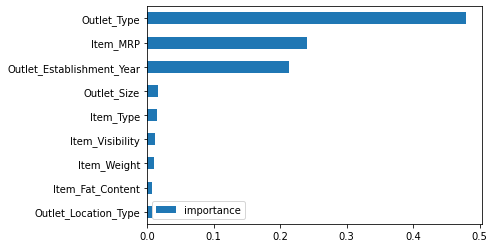

In [ ]:
fi.plot.barh()

In [ ]:
x_new=x[['Outlet_Type','Item_MRP','Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type']]

In [ ]:
x_new.head(1)

,Outlet_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type
0,1,249.8092,1999,1,0


* we have selected the most important features that can predict the sales with more accuracy.

In [ ]:
##x_new=scalar.fit_transform(x_new)

In [ ]:
x_new

,Outlet_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type
0,1,249.8092,1999,1,0
1,2,48.2692,2009,1,2
2,1,141.6180,1999,1,0
3,0,182.0950,1998,2,2
4,1,53.8614,1987,0,2
...,...,...,...,...,...
8518,1,214.5218,1987,0,2
8519,1,108.1570,2002,2,1
8520,1,85.1224,2004,2,1
8521,2,103.1332,2009,1,2


In [ ]:
y.head(2)

0    3735.1380
1     443.4228
Name: Item_Outlet_Sales, dtype: float64

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(x_new,y,test_size=0.2)

In [ ]:
model2=XGBRegressor(n_estimators=100)

In [ ]:
model2.fit(X_train,Y_train)

[10:53:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
Y_pred=model2.predict(X_test)

In [ ]:
metrics.r2_score(Y_test,Y_pred)

0.6148219312784585